# Community detection (graph-tool nested blockmodel): analyzing communities of artists in our network who also appear in the PainterPalette dataset

Previously, we have collected ~22k artists from the e-flux website, and created a network of them based on coexhibition. We do not have any data on artists however.

From PainterPalette, we have information on ~10000 painters/artists, the intersection of the two artist datasets come out to have around 1000 artists. For these artists that span from the 7th century (even before, but with nearly no info) to the 21st, we have information about their lifetime (work) locations, time data, gender, nationality, how many artworks they painted per style, what movement they belonged to, a list of some of the painters who influenced them and who they influenced, the school they studied at and friends and coworkers. 

From the work described in this notebook, we gained insights about what common properties do communities of artists have, that were connected by coexhibitions. What describe the communities that we can find among them (with statistical tools)? Are these communities fairly even in percentage of females, or vary a lot? From very simple analysis before, we found that centuries ago the surroundings of a painter pretty much determined his/her artistic style too (social contagion). As transportation infrastructure developed (assumably that is the reason), the various styles started spreading more, and while location (in time) used to be a good indicator of an artistic style, it does not have as much of an impact anymore. <br>

## Initial steps

In [3]:
#import graph_tool as gt
#from graph_tool import inference
from graph_tool.all import * #Otherwise, draw_hierarchy will not be found in any case (even if importing graph_tool.draw)

In [63]:
import json
import pandas as pd

with open('data/artists_cleaned_v1.txt', 'r', encoding='utf-8') as f:
    artists = f.read().splitlines()

with open('data/announcements.json', 'r', encoding='utf-8') as f:
    announcements = json.load(f)

url = "https://raw.githubusercontent.com/me9hanics/PainterPalette/main/PainterPalette.csv"
artists_df = pd.read_csv(url).drop(columns=['Type', 'Contemporary'])
#I often include this way, don't have to download, plus keeps track of updates
#dropping type and contemporary because they are "artificial" columns

#Get the PainterPalette artists coexhibition network
g_selected = load_graph("data/selected_artists_network.gt.gz")

Just to give an example, this is what data we have of one artist:

In [12]:
(artists[0:1]).iloc[0].squeeze()

artist                                                      Bracha L. Ettinger
Nationality                                              French,Jewish,Israeli
citizenship                                                             Israel
gender                                                                  female
styles                                                   New European Painting
movement                                                 New European Painting
Art500k_Movements                                   {New European Painting:21}
birth_place                                                           Tel Aviv
death_place                                                                NaN
birth_year                                                              1948.0
death_year                                                                 NaN
FirstYear                                                               1991.0
LastYear                                            

Let's fit a (nested) blockmodel on them to see if we can find some things in common in communities:<br> (this is statistical method of finding communities in graphs, advantage over modular is that it is arguably less biased)

In [37]:
state = minimize_nested_blockmodel_dl(g_selected)
#state.draw(output="images/artists_selected_block_model.png") #SVG is nicer, but this would take too long to render

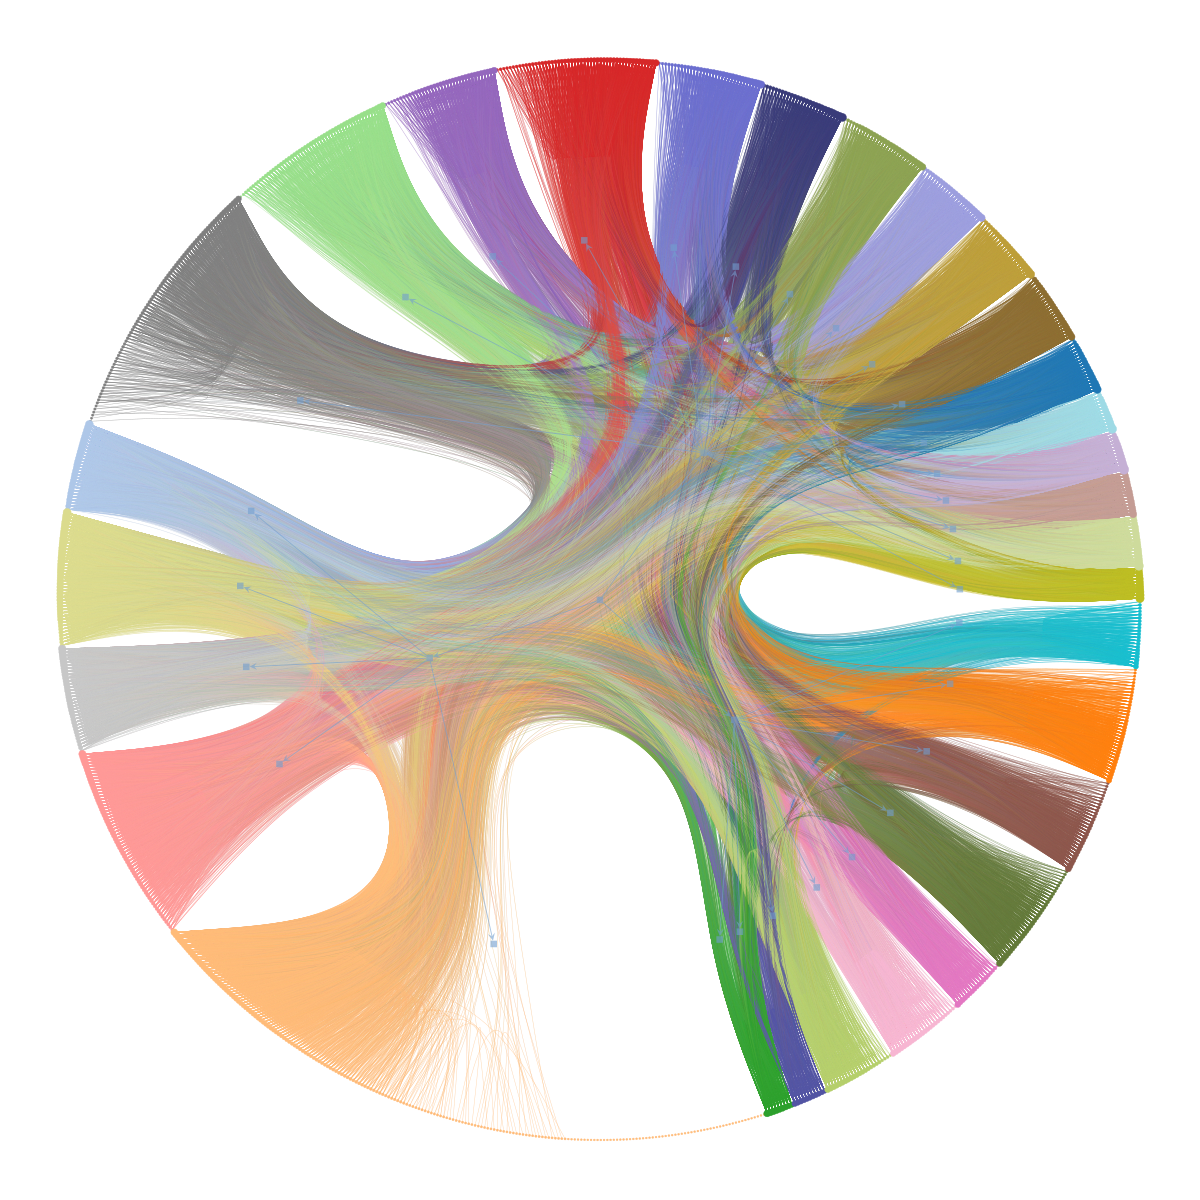

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7beca6761250, at 0x7bef253ceb90>,
 <GraphView object, directed, with 1077 vertices and 1076 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7beca69af3d0, at 0x7beca679f610>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7beca69af3d0, at 0x7beca5d6f210>, False), at 0x7beca69af3d0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7beca69af3d0, at 0x7beca676e250>)

In [39]:
state.draw()

In [41]:
state.levels[0]

<BlockState object with 1043 blocks (30 nonempty), degree-corrected, for graph <Graph object, undirected, with 1043 vertices and 53003 edges, 1 internal vertex property, 1 internal edge property, at 0x7beca6761250>, at 0x7beca5d1f350>

The artists were split into 30 communities. The disadvantage of the model is that it is incapable of finding truly small communities (the nested blockmodel because of the nested architecture, can find relatively small communities), simply because they are statistically more likely of existing. 

(Think about it like this: since we have 53003 edges out of 530k possibilites, between two nodes the chance of an edge existing is roughly 10%. Assuming random generation, for selecting a group of 6 people, the chance of them having all of them connected is 0.1^15, as 15 equals ${6 \choose 2}$, likewise 0.1^10 for a group of 5 people. This way, a totally random generation will have on average $\frac{{1043 \choose 6}}{10^{15}}=~1.76$ and $\frac{{1043 \choose 5}}{10^{10}} = ~1019$ groups of 6 and 5 respectively. This means that finding a totally connected group of 6 is not an outstanding community statistically, and if we look for groups that do not have all edges, these groups are even more common statistically. This means that all our communities will likely be bigger than size of 6, and indeed this is true, below we will observe that the smallest community is a group of 8.)

Another problem with this particular implementation is that (as far as I know), there is no seed to give to obey getting different random results everytime. This is a problem for reproducability, and we had to re-run some things (there may be some inaccuracies this way). 

## Analysis

In [42]:
b = state.levels[0].get_blocks()

#Create a look up table of block ids and included artist names (similar to vertex id - artist name mapping)
block_to_artist = {}
for v in g_selected.vertices():
    block_id = b[v]
    artist = g_selected.vertex_properties["name"][v]
    if block_id not in block_to_artist:
        block_to_artist[block_id] = [] #Create the list, put the artist in it below
    block_to_artist[block_id].append(artist)

Get the information containing dataframe (not necessary, but why not)

In [43]:
artists_selected = artists[artists['artist'].isin(artists_in_both)]

Some functions (not worthy to make a file for them):

In [60]:
import ast #Useful for converting strings to lists, dicts etc.

def get_column_counts(artists_df, column):
    return (artists_df[column]).value_counts()

def get_column_counts_adjusted(artists_df, column):
    return (artists_df[column]).value_counts(normalize=True)

def get_column_average(artists_df, column):
    return (artists_df[column]).mean()

def get_column_std(artists_df, column):
    return (artists_df[column]).std()

def get_locations_average(artists_df):
    all_people_locations = []
    for index, row in artists_df.iterrows():
        locations = ast.literal_eval(row['locations']) #List
        all_people_locations.extend(locations)

    return pd.Series(all_people_locations).value_counts(normalize=True)

def get_female_percentage(artists_df):
    values = (artists_df['gender'].value_counts(normalize=True))
    try:
        values_known = values['male'] + values['female']
    except KeyError: #Either no 'male' or 'female' (therefore values has no such key)
        try: #Assume no females
            values_known = values['male']
            if values_known == 0:
                return None
            else :
                return 0
        except KeyError: #KeyError on males
            try: #Assume no males
                values_known = values['female']
                if values_known == 0:
                    return None
                else:
                    return 100
            except KeyError:#No males or females (shouldn't happen)
                return None
    return 100*values['female'] / values_known

Global averages for all artists in PainterPalette:

In [34]:
get_column_counts_adjusted(artists, 'Nationality')

Nationality
American                  0.149137
French                    0.094495
British                   0.081758
Italian                   0.078882
German                    0.046015
                            ...   
Argentinean,Slovak        0.000411
French,Armenian           0.000411
Austrian,Brazilian        0.000411
Russian,Polish,Latvian    0.000411
American,Dutch            0.000411
Name: proportion, Length: 288, dtype: float64

It would have made more sense to deal with the multiple nationalities by splitting at commas, but they do not make much of a difference.

Ratio of nationalities for the selected 1000 artists:

In [59]:
get_column_counts_adjusted(artists_selected, 'Nationality')

Nationality
American                  0.280093
French                    0.085648
Italian                   0.085648
German                    0.081019
British                   0.067130
                            ...   
American,Japanese         0.002315
Iranian,American          0.002315
German,Swiss,Icelandic    0.002315
Argentinean,Slovak        0.002315
French,Romanian           0.002315
Length: 101, dtype: float64

As we can see, there are much more American artists among the selected artists than originally in the dataset, which highlights a bias towards American artists on the e-flux website. 

Average amount of females (percentage)

In [72]:
female_percentage_selected = round(get_female_percentage(artists_selected), 2)
female_percentage_df = round(get_female_percentage(artists_df), 2)

print(f"Female percentage in artists_selected: {female_percentage_selected}%")
print(f"Female percentage in artists: {female_percentage_df}%")

Female percentage in artists_selected: 26.77%
Female percentage in artists: 11.74%


In [91]:
import numpy as np
np.min(artists_selected['birth_year'])

699.0

We see a marginal increase in the amount of females in the selected dataset, which means that the website also features more women (since it includes more contemporary artists, this makes sense). Might be worth looking into how many of American artists are female:

In [45]:
artists_americans = artists_selected[(artists_selected['Nationality']=='American') | artists_selected['citizenship'].str.contains('United States')]
get_female_percentage(artists_americans)

30.08474576271186

Even higher. Now let's look at the communities; we collect the data of various properties for each community:

In [61]:
blocks_nationality = []; blocks_citizenship = []; blocks_gender = []; blocks_birth_year = []; blocks_wikiart_pictures_count = []; blocks_styles = []; blocks_movement = []; blocks_size = []
for block_id, artists_in_block in block_to_artist.items():
    artists_in_block_df = artists_selected[artists_selected['artist'].isin(artists_in_block)]
    blocks_nationality.append(get_column_counts_adjusted(artists_in_block_df, 'Nationality'))
    blocks_citizenship.append(get_column_counts_adjusted(artists_in_block_df, 'citizenship'))
    blocks_gender.append(get_female_percentage(artists_in_block_df))
    blocks_birth_year.append(get_column_average(artists_in_block_df, 'birth_year'))
    blocks_wikiart_pictures_count.append(get_column_average(artists_in_block_df, 'wikiart_pictures_count'))
    blocks_styles.append(get_column_counts_adjusted(artists_in_block_df, 'styles'))
    blocks_movement.append(get_column_counts_adjusted(artists_in_block_df, 'movement'))
    
    blocks_size.append(len(artists_in_block))
#DF
block_data = pd.DataFrame({'Size':blocks_size, 'Nationality': blocks_nationality, 'citizenship': blocks_citizenship, 'gender': blocks_gender, 'birth_year': blocks_birth_year, 'wikiart_pictures_count': blocks_wikiart_pictures_count, 'styles': blocks_styles, 'movement': blocks_movement})


The below results, because of the randomness of the algorithm, gave different results from the one we showed when presenting.

In [66]:
block_data.sort_values(by='birth_year', ascending=True)

,Size,Nationality,citizenship,gender,birth_year,wikiart_pictures_count,styles,movement
20,21,Nationality Chinese 0.75 Indian 0.25 Na...,citizenship People's Republic of China 0.3 ...,19.047619,1797.809524,19.875000,styles Maximalism ...,movement Maximalism 0...
23,13,Nationality French 0.222222 Americ...,citizenship France 0.23...,0.000000,1856.076923,377.916667,"styles Abstract Art, Cubism, Dada, Surrealism ...",movement Dada 0.166667 P...
10,84,Nationality French 0.28260...,citizenship France ...,29.268293,1870.369048,132.137931,styles Surrealism ...,movement Surrealism 0.172414 E...
6,25,Nationality French 0.3888...,citizenship France ...,0.000000,1882.120000,138.055556,"styles Expressionism, Unknown ...",movement Expressionism 0.222222 Abstra...
29,23,Nationality Italian 0.142857 ...,citizenship France 0.17...,13.043478,1893.739130,127.904762,"styles Abstract Art, Expressionism, Fauvism, I...",movement Expressionism 0.190476 Abstrac...
9,29,Nationality German 0.176471...,citizenship France 0.21...,24.137931,1904.344828,45.941176,styles Pop Art ...,movement Abstract Art 0.117647 C...
15,50,Nationality American 0.4000...,citizenship United States of America 0.39...,24.000000,1908.840000,102.450000,"styles Expressionism, Unknown ...",movement Expressionism 0.40 Abstract Art ...
21,30,Nationality American 0.695652 Mexi...,citizenship United States of America ...,10.000000,1909.900000,66.916667,"styles Abstract Art, Abstract Expressionism, C...",movement Abstract Expressionism ...
28,13,Nationality American 0.363636 German...,citizenship United States of America 0.7272...,16.666667,1918.083333,107.909091,"styles Abstract Art, Abstract Expressionism, A...",movement Abstract Art 0.27272...
14,33,Nationality American 0.526316 ...,citizenship United States of America ...,9.090909,1918.515152,23.217391,styles Conceptual Art ...,movement Conceptual Art 0.260...


We see just by looking at the dataframe that the communities are quite nationality-based, which is of course expected. We can observe many nationality-communities:

- An early Asian (Chinese, Indian, Japanese) community of artists, the earliest by birth year
- 3 French groups, 2nd, 3rd, and 4th earliest by birth year, in styles mostly expressionism, surrealism and
- 4 (arguably 5) mostly Italian communities, two Arte Povera style communities, one conceptual art and one contemporary style.
- Very many US-dominated communities
- Abstract art communities have mostly European nationalities, but already very mixed, whereas Contemporary style communities have mostly US citizens. 

A limitation is that the French groups were quite mixed in style, and thus the impressionists were split among the 3 mentioned French groups, and not found as one community. 

In a different run, this was the result we got (39 communities):<br>
- One full Indian block (13 artists, although some no nationality artists may not have been Indian)<br>
- One 16.6% Romanian, Israeli / Jewish 16.6% (29 artist) <br>
- One group for: Russians (10%), Chinese (27%), German-Dutch (20-20%), Brazilians (25%), Dutch (21%), Japan (16%) <br>
- 2 German (29% and 15%), UK (2x28%), 3 French (Impressionism+Surrealism+Abstract Expressionism, 29%, 30%, 35%) + 1 artist group where only 22% of artists were born as French but most became citizens <br>
- ”Almost made it” (2nd after Americans): one group of Nigerians (11%), Austrians (28%) <br>
- Italians: 5 groups, as high as 66%<br>
- All others: American dominance (as high as 82%)

### Female percentage analysis

We've already seen that the average female percentage is 26.77%. Let's look at the median:

In [96]:
block_data['gender'].sort_values(ascending=False).values[15] #14 gives 24.2%, so the real median is 24.1%, but we just looked at this as curiousity

24.0

Now let's visualize the distribution of female percentages in the communities. We could have used histograms, but ordering the communities by values, and plotting the values themselves seemed to give a simpler picture.

In [109]:
block_data['movement'][23]

movement
Dada                       0.166667
Post-Impressionism         0.166667
Expressionism              0.166667
Abstract Expressionism     0.083333
Outsider art (Art brut)    0.083333
High Renaissance           0.083333
Impressionism              0.083333
Metaphysical art           0.083333
Surrealism                 0.083333
Name: proportion, dtype: float64

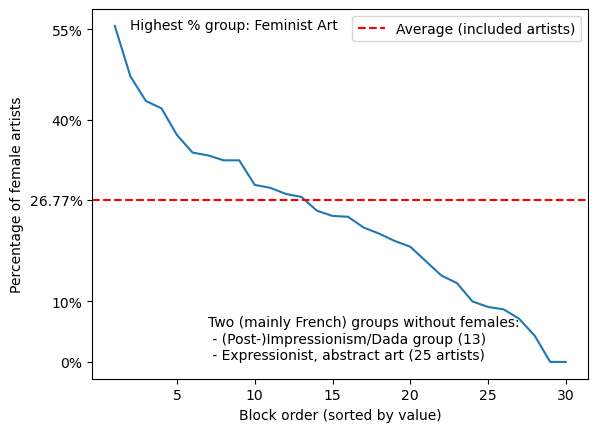

In [124]:
#Plot gender
import matplotlib.pyplot as plt

plt.plot(block_data['gender'].sort_values(ascending=False).values)
plt.ylabel('Percentage of female artists')
plt.xlabel('Block order (sorted by value)')
#Add ticks, with percentages
plt.xticks([4,9,14,19,24, 29], labels=['5', '10', '15', '20','25', '30' ])
plt.yticks([0, 10, 26.77, 40, 55], labels=['0%', '10%', '26.77%', '40%', '55%'])
plt.axhline(y=26.77, color='r', linestyle='--', label="Average (included artists)")
plt.legend()
plt.text(6, 0.5, 'Two (mainly French) groups without females:\n - (Post-)Impressionism/Dada group (13)\n - Expressionist, abstract art (25 artists)')
plt.text(1, 55, 'Highest % group: Feminist Art');

Looking more into it, seems like lower percentages seem to come from earlier centuries.

Let's try to "prove" that:

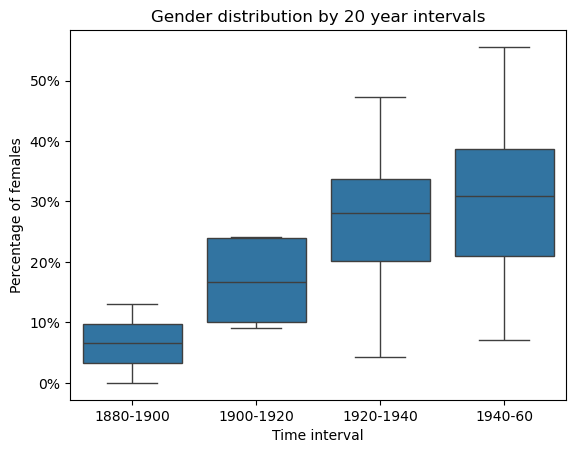

In [168]:
import seaborn as sns
import numpy as np

#Simplifying to 5 decades. Skipping the Asian group and two French as they are the only groups in that time period
block_data['century'] = (block_data['birth_year'] // 20).astype(int)
plot_data = block_data.sort_values(by='birth_year', ascending=True)[3:]

sns.boxplot(x='century', y='gender', data=plot_data)
plt.xlabel('Time interval')
plt.ylabel('Percentage of females')
plt.title('Gender distribution by 20 year intervals')
plt.xticks(np.arange(0, 4), ['1880-1900', '1900-1920', '1920-1940', '1940-60'])
plt.yticks([0,10,20,30, 40, 50], ["0%","10%","20%","30%", "40%","50%"])

plt.show()

Indeed, we see this upward going trend. This may be a sign that more and more percentage of women work as artists; or a sign that we collect more and more data of female artists throughout the years.

### Birthyears of communities

Text(-1, 1934, 'Five earliest communities (alone in their decades): \n - Chinese, Indian, Japanese artist group (before 18th century) \n - French: Dada/(Post)-Impressionism (1856),\n   Symbolism (1870), Expressionism (1882) \n - Italian-French Expressionism (1893)')

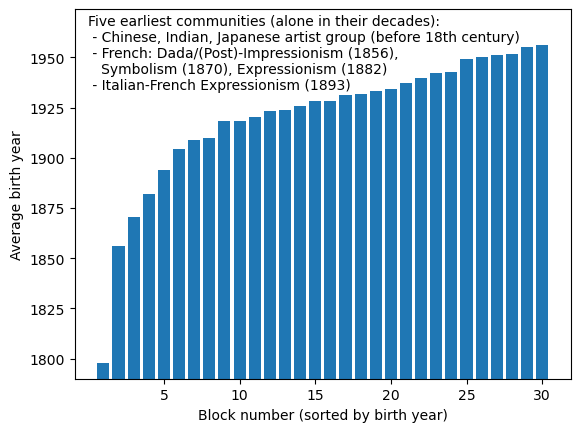

In [147]:
#Plot birth year
plt.bar(range(len(block_data['birth_year'])), block_data['birth_year'].sort_values(ascending=True).values)
plt.ylim(1790, 1974)
plt.ylabel('Average birth year')
plt.xlabel('Block number (sorted by birth year)')
plt.xticks([4,9,14,19,24, 29], labels=['5', '10', '15', '20','25', '30' ])
plt.text(-1, 1934, "Five earliest communities (alone in their decades): \n - Chinese, Indian, Japanese artist group (before 18th century) \n - French: Dada/(Post)-Impressionism (1856),\n   Symbolism (1870), Expressionism (1882) \n - Italian-French Expressionism (1893)")

We see that there are some outstanding groups at the lower end, these are the already mentioned communities. If we look deeper in the data, we see a trend again that earlier communities have higher "main nationality percentage" (e.g., a large % of the group represent one nationality), whereas lately it is more mixed.

### WikiArt pictures count: average per artist, plotted for all communities

This is a not bad measure of success, at least for 19th-20th century artists. (Older centuries have less paintings reserved.)

Text(1, 345, 'Top group:\n - The mostly French group of Expressionists,\n   (Post-)Impressionists, Dadaists')

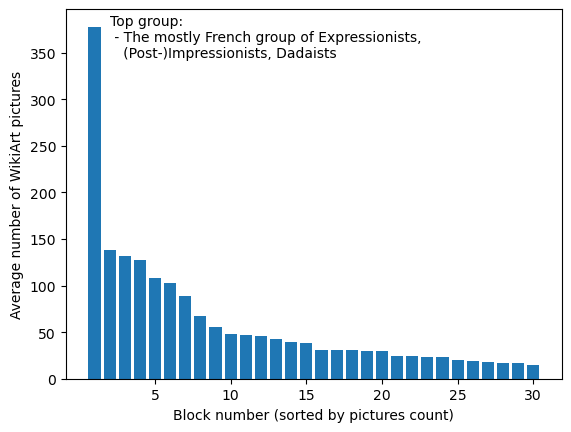

In [166]:
plt.bar(range(len(block_data['wikiart_pictures_count'])), block_data['wikiart_pictures_count'].sort_values(ascending=False).values)
plt.ylabel('Average number of WikiArt pictures')
plt.xlabel('Block number (sorted by pictures count)')
plt.xticks([4,9,14,19,24, 29], labels=['5', '10', '15', '20','25', '30' ])
plt.text(1, 345, 'Top group:\n - The mostly French group of Expressionists,\n   (Post-)Impressionists, Dadaists',)

We see one standout group, that is again the most notable group, being an "outlier" in all categories. Among the other high average communities (e.g., above 100), all of them are among the earliest group by average birth year.